## 1. Preprocessing

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone
from sklearn import preprocessing

Reading CSV:

In [0]:
df=pd.read_csv("train.csv")

First look:

In [4]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,200189,NaN,NaN,NaN,13661,8170.42,500,7500,12000,18700,35000
term,200189,2,36 months,153900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,200189,NaN,NaN,NaN,13.8778,4.42672,5.32,10.99,13.66,16.78,28.99
installment,200189,NaN,NaN,NaN,420.482,245.688,15.69,242.55,367.13,549.74,1424.57
grade,200189,7,B,58822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,200189,35,B3,13915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,189062,107730,Manager,1599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,192135,11,10+ years,60786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,200189,6,MORTGAGE,98279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,200189,NaN,NaN,NaN,72374.5,57375.1,3000,45000,62000,87000,8.70658e+06


"Policy_code" has only 1 unique value. We will drop it.

In [5]:
df["policy_code"].unique()

array([1.])

In [0]:
drop_vars=["policy_code"]

Unique values of grade and sub_grade variables:

In [7]:
df[["grade","sub_grade"]].groupby(["grade"]).apply(np.unique)

grade
A    [A, A1, A2, A3, A4, A5]
B    [B, B1, B2, B3, B4, B5]
C    [C, C1, C2, C3, C4, C5]
D    [D, D1, D2, D3, D4, D5]
E    [E, E1, E2, E3, E4, E5]
F    [F, F1, F2, F3, F4, F5]
G    [G, G1, G2, G3, G4, G5]
dtype: object

We can see, any value of grade has unique values only from its own sub-group. So, we can drop "grade" variable. "sub_grade"  will be turned into an integer, because all its values are comparable.

In [0]:
drop_vars.append("grade")

In [9]:
a=np.sort(df["sub_grade"].unique()).tolist()
le=preprocessing.LabelEncoder()
le.fit(a)
le.transform(a)
df["sub_grade"]=le.transform(df["sub_grade"])
df["sub_grade"]

0          7
1          0
2          6
3         12
4          9
5         11
6         17
7         11
8         10
9         19
10        10
11         7
12         7
13         9
14         2
15         8
16         7
17        14
18        22
19        17
20         9
21         5
22        15
23        17
24         8
25         9
26         4
27        23
28         9
29         3
          ..
200159    14
200160     3
200161    20
200162    21
200163    13
200164     3
200165     7
200166     6
200167    21
200168    12
200169    15
200170    11
200171     2
200172    22
200173    12
200174     4
200175     3
200176     9
200177     9
200178    29
200179    32
200180    11
200181     9
200182     9
200183    13
200184    21
200185     5
200186     7
200187    21
200188    15
Name: sub_grade, Length: 200189, dtype: int64

"Record_id" isn't present in dataset description, and unlikely is useful. "emp_title" has a big amount of unique categorical values.There are no values, which appear in more than 1% (2000 observations) of the whole dataset. Zipcode has a big amount of unique values and is unnesessary, because there is addr_state variable.
We'll drop those variables.

In [10]:
len(df["record_id"].unique())==df["record_id"].shape[0]

True

In [0]:
drop_vars.append("record_id")

In [12]:
sum(df["emp_title"].value_counts()>2000)

0

In [13]:
drop_vars=drop_vars+["emp_title","zip_code"]
drop_vars

['policy_code', 'grade', 'record_id', 'emp_title', 'zip_code']

List of the variables with NA values:

In [14]:
na_vars=df.columns[df.isna().any()].tolist()
df[na_vars].head(6).T

,0,1,2,3,4,5
emp_title,Quality Assurance Specialist,NaN,KIPP NYC,Receptionist,Medtox Laboratories,Melrose-Sovereign Companies
emp_length,4 years,NaN,3 years,< 1 year,10+ years,4 years
mths_since_last_delinq,NaN,NaN,NaN,47,NaN,NaN
revol_util,61.2,26.3,60.5,46.9,82.4,51.1
collections_12_mths_ex_med,0,0,0,0,0,0
tot_coll_amt,0,0,193,165,NaN,NaN
tot_cur_bal,295215,25130,41737,28187,NaN,NaN
total_rev_hi_lim,20500,14200,19448,14500,NaN,NaN


Fraction of NA's for each variable:

In [15]:
df[na_vars].isna().mean().sort_values(ascending=False)

mths_since_last_delinq        0.552318
total_rev_hi_lim              0.239559
tot_cur_bal                   0.239559
tot_coll_amt                  0.239559
emp_title                     0.055582
emp_length                    0.040232
revol_util                    0.000769
collections_12_mths_ex_med    0.000220
dtype: float64

"tot_cur_bal", "tot_coll_amt", "total_rev_hi_lim" have the same NA fraction. Are their NA indexes the same?

In [16]:
tot_vars=["tot_cur_bal", "tot_coll_amt", "total_rev_hi_lim"]
a=((
    df["tot_cur_bal"].isna()==
    df["tot_coll_amt"].isna()).all())
b=((
    df["tot_cur_bal"].isna()==
    df["total_rev_hi_lim"].isna()).all())
if a & b:
    print("Yes, they are")
else:
    print("No, they aren't")

Yes, they are


We'll make new categorical varibales for NA fraction of "mths_since_last_delinq", "tot_vars", and fill missing values with 0.

In [17]:
fill_list=tot_vars+["mths_since_last_delinq"]
df["tot_vars_NA"]=0
df.loc[df[tot_vars[0]].isna(),("tot_vars_NA")]=1
for i in fill_list:
    if i=="mths_since_last_delinq":
      df[i+"_NA"]=0
      df.loc[df[i].isna(),(i+"_NA")]=1
    df[i].fillna(value=0,inplace=True)
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,200189,NaN,NaN,NaN,13661,8170.42,500,7500,12000,18700,35000
term,200189,2,36 months,153900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,200189,NaN,NaN,NaN,13.8778,4.42672,5.32,10.99,13.66,16.78,28.99
installment,200189,NaN,NaN,NaN,420.482,245.688,15.69,242.55,367.13,549.74,1424.57
grade,200189,7,B,58822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,200189,NaN,NaN,NaN,11.177,6.66639,0,6,10,15,34
emp_title,189062,107730,Manager,1599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,192135,11,10+ years,60786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,200189,6,MORTGAGE,98279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,200189,NaN,NaN,NaN,72374.5,57375.1,3000,45000,62000,87000,8.70658e+06


Processing "emp_length" variable: values "10+ years" will be replaced with number 15, as the mean of that frequency of population. NA's will be replaced with random values from var's distribution.

In [18]:
df["emp_length"].unique()

array(['4 years', nan, '3 years', '< 1 year', '10+ years', '8 years',
       '6 years', '5 years', '2 years', '1 year', '7 years', '9 years'],
      dtype=object)

In [19]:
na_ind=df["emp_length"].isna()
na_num=na_ind.sum()
t=df[~na_ind]["emp_length"].value_counts(normalize=True)
emp_p=t.tolist()
emp_ind=t.index
emp_ind

Index(['10+ years', '2 years', '< 1 year', '3 years', '5 years', '1 year',
       '4 years', '6 years', '7 years', '8 years', '9 years'],
      dtype='object')

In [20]:
df.loc[na_ind,"emp_length"]=np.random.choice(emp_ind,size=na_num,p=emp_p)
df.loc[na_ind,"emp_length"]

1           8 years
6           6 years
8           9 years
26          3 years
29        10+ years
42          2 years
45         < 1 year
62        10+ years
81          8 years
124       10+ years
150        < 1 year
159        < 1 year
191         4 years
193       10+ years
207       10+ years
237        < 1 year
246        < 1 year
304         2 years
335         8 years
337       10+ years
377         5 years
411        < 1 year
419        < 1 year
457        < 1 year
536          1 year
541         6 years
555         2 years
562         6 years
570        < 1 year
612         5 years
            ...    
199376    10+ years
199394     < 1 year
199420      5 years
199469      7 years
199555    10+ years
199638    10+ years
199655      7 years
199662      7 years
199671      4 years
199680      3 years
199728      4 years
199766     < 1 year
199788      3 years
199794       1 year
199906    10+ years
199947      3 years
199965      9 years
199998    10+ years
200009      5 years


In [0]:
def repl (x):
    if x.startswith("<"):
        return 0
    elif x.startswith("10"):
        return 15
    else:
        return int(x[0])

In [23]:
df["emp_length"]=df["emp_length"].apply(repl)
df["emp_length"]

0          4
1          8
2          3
3          0
4         15
5          4
6          6
7         15
8          9
9          3
10        15
11         4
12        15
13        15
14         4
15        15
16         8
17         6
18        15
19        15
20         5
21         8
22        15
23         0
24        15
25         2
26         3
27         4
28        15
29        15
          ..
200159     4
200160     3
200161    15
200162     8
200163     5
200164     9
200165    15
200166     3
200167     0
200168    15
200169    15
200170    15
200171     0
200172     6
200173    15
200174     6
200175    15
200176    15
200177     3
200178     6
200179     1
200180     6
200181     2
200182     2
200183     8
200184    15
200185     2
200186     5
200187     7
200188     3
Name: emp_length, Length: 200189, dtype: int64

Dropping "drop_vars": 

In [24]:
df.drop(labels=drop_vars,axis=1, inplace=True)
df.head(1).T

,0
loan_amnt,15000
term,36 months
int_rate,11.99
installment,498.15
sub_grade,7
emp_length,4
home_ownership,MORTGAGE
annual_inc,70000
verification_status,Verified
issue_d,Oct-2013


Updating NA variables:

In [25]:
na_vars=df.columns[df.isna().any()].tolist()
(df[na_vars].isna().sum()/df.shape[0]).sort_values(ascending=False)

revol_util                    0.000769
collections_12_mths_ex_med    0.000220
dtype: float64

We'll drop the observations where the values of  other variables are missing, because its fraction fraction is quite small.

In [26]:
df.dropna(inplace=True,subset=na_vars)
df.columns[df.isna().any()].tolist()

[]

Removing categories with small fraction of "addr_state" variable.

In [27]:
t=df["addr_state"].value_counts(normalize=True)
thr=0.2
state_list=t[t>t.max()*thr].index.tolist()
state_list
state_ind=df["addr_state"].isin(state_list)
df["addr_state"].loc[~state_ind]="DEFAULT"
df["addr_state"].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


DEFAULT    105063
CA          33827
NY          17064
TX          15395
FL          13912
NJ           7555
IL           7175
Name: addr_state, dtype: int64

Processing date variables:

In [0]:
date_vars=["earliest_cr_line","issue_d"]

In [0]:
for i in date_vars:
    t=pd.to_datetime(df[i])
    df[i+"_year"]=t.dt.year
#    df[i+"_month"]=t.dt.month
df.drop(labels=date_vars,axis=1, inplace=True)

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,199991.0,13665.098804,8168.803273,500.00,7500.00,12000.00,18700.00,35000.00
int_rate,199991.0,13.877024,4.426677,5.32,10.99,13.66,16.78,28.99
installment,199991.0,420.599910,245.633541,15.69,242.57,367.25,549.80,1424.57
sub_grade,199991.0,11.174458,6.665285,0.00,6.00,10.00,15.00,34.00
emp_length,199991.0,7.409228,5.636605,0.00,2.00,6.00,15.00,15.00
annual_inc,199991.0,72363.419528,57339.924948,3000.00,45000.00,62000.00,87000.00,8706582.00
loan_status,199991.0,0.777575,0.415876,0.00,1.00,1.00,1.00,1.00
dti,199991.0,16.712423,7.851729,0.00,10.87,16.37,22.19,57.14
delinq_2yrs,199991.0,0.257617,0.755798,0.00,0.00,0.00,0.00,22.00
inq_last_6mths,199991.0,0.851203,1.067636,0.00,0.00,1.00,1.00,8.00


In [31]:
num_vars=list(df.dtypes[df.dtypes!=np.dtype('O')].index)
num_vars

['loan_amnt',
 'int_rate',
 'installment',
 'sub_grade',
 'emp_length',
 'annual_inc',
 'loan_status',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'tot_vars_NA',
 'mths_since_last_delinq_NA',
 'earliest_cr_line_year',
 'issue_d_year']

## 2. EDA

In [32]:
df.describe()

,loan_amnt,int_rate,installment,sub_grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,tot_vars_NA,mths_since_last_delinq_NA,earliest_cr_line_year,issue_d_year
count,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000
mean,13665.098804,13.877024,420.599910,11.174458,7.409228,7.236342e+04,0.777575,16.712423,0.257617,0.851203,15.674005,10.984509,0.147737,15147.801006,54.532562,25.053412,0.007380,0.003390,121.648389,1.041987e+05,2.240685e+04,0.239281,0.552430,1997.652114,2012.947098
std,8168.803273,4.426677,245.633541,6.665285,5.636605,5.733992e+04,0.415876,7.851729,0.755798,1.067636,22.727824,4.911751,0.446100,18112.585109,24.759526,11.755008,0.093947,0.064021,1478.639995,1.435205e+05,2.799324e+04,0.426646,0.497245,7.009654,1.441099
min,500.000000,5.320000,15.690000,0.000000,0.000000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1946.000000,2007.000000
25%,7500.000000,10.990000,242.570000,6.000000,2.000000,4.500000e+04,1.000000,10.870000,0.000000,0.000000,0.000000,8.000000,0.000000,5876.000000,36.600000,16.000000,0.000000,0.000000,0.000000,4.007000e+03,3.500000e+03,0.000000,0.000000,1994.000000,2012.000000
50%,12000.000000,13.660000,367.250000,10.000000,6.000000,6.200000e+04,1.000000,16.370000,0.000000,1.000000,0.000000,10.000000,0.000000,10946.000000,56.000000,23.000000,0.000000,0.000000,0.000000,3.949200e+04,1.620000e+04,0.000000,1.000000,1999.000000,2013.000000
75%,18700.000000,16.780000,549.800000,15.000000,15.000000,8.700000e+04,1.000000,22.190000,0.000000,1.000000,28.000000,14.000000,0.000000,19060.000000,74.000000,32.000000,0.000000,0.000000,0.000000,1.655920e+05,3.090000e+04,0.000000,1.000000,2002.000000,2014.000000
max,35000.000000,28.990000,1424.570000,34.000000,15.000000,8.706582e+06,1.000000,57.140000,22.000000,8.000000,151.000000,76.000000,12.000000,975800.000000,892.300000,118.000000,6.000000,5.000000,296368.000000,8.000078e+06,1.035000e+06,1.000000,1.000000,2012.000000,2015.000000


Response variable distribution:

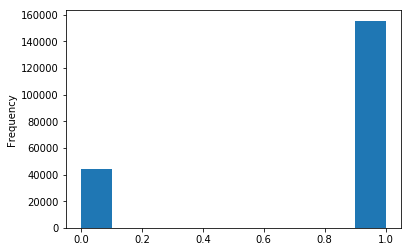

In [33]:
df["loan_status"].plot(kind="hist")

Plotting correlation matrix for numerical variables:

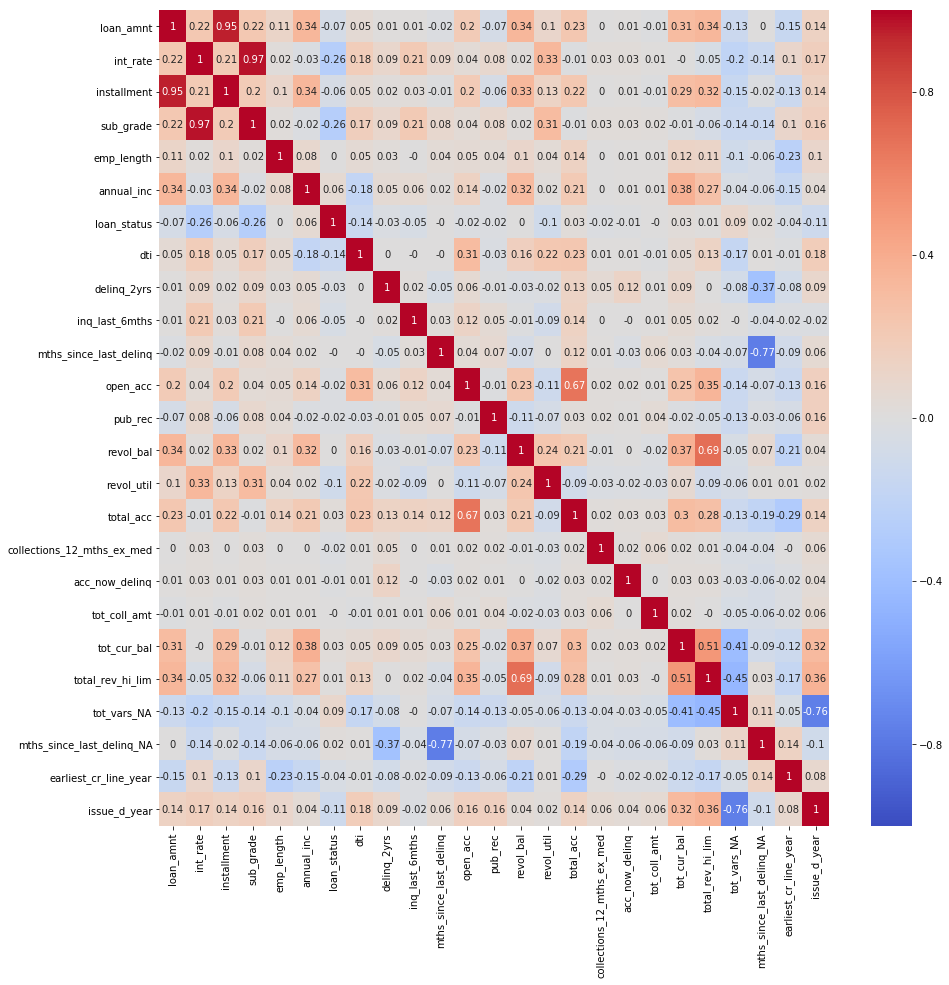

In [34]:
corr = df[num_vars].corr()
corr=corr.applymap(lambda x: float("{0:.2f}".format(x)))
plt.figure(figsize=(15,15))
sns.heatmap(corr,
            vmin=-1,
            cmap='coolwarm', annot=True)

## 3. Modelling

Getting response variable:

In [0]:
y=df["loan_status"]
df.drop(labels=["loan_status"],axis=1, inplace=True)

Inverting classes of response variable for further interpretation proposes:

In [0]:
y=1-y

Splitting into the train and test sets:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df,y,test_size=0.3, random_state=30, stratify=y)

Getting the list of object variables:

In [38]:
obj_vars=list(df.dtypes[df.dtypes==np.dtype('O')].index)
df[obj_vars].describe().T

,count,unique,top,freq
term,199991,2,36 months,153732
home_ownership,199991,6,MORTGAGE,98190
verification_status,199991,3,Verified,73373
pymnt_plan,199991,2,n,199985
purpose,199991,14,debt_consolidation,117885
addr_state,199991,7,DEFAULT,105063
initial_list_status,199991,2,f,142020
application_type,199991,2,INDIVIDUAL,199988


Transforming them with One-Hot-Encoder in train and test sets separately


In [0]:
X_train=pd.get_dummies(X_train,columns=obj_vars)
X_test=pd.get_dummies(X_test,columns=obj_vars)

Comparing categories in train and test sets. dropping unique columns of test set.

In [40]:
a=set(X_train.columns.values)
b=set(X_test.columns.values)
print(a.difference(b))
print(b.difference(a))

{'home_ownership_ANY'}
set()


In [0]:

X_test.drop(labels=list(b.difference(a)),axis=1, inplace=True)
c= list(a.difference(b))
for i in c:
  X_test[i]=0

Casting dataframe into float:

In [0]:
X_train = X_train.astype(dtype="float64")
X_test = X_test.astype(dtype="float64")

Undersampling on train set:

In [0]:
def samp(y,rat):
    pos_ind=y[y==1].index
    n = pos_ind.shape[0]
    neg_ind= y[y==0].sample(n=int(n*rat)).index
    return pos_ind.append(neg_ind)


In [0]:
samp_ind=samp(y_train,1)

Log regression pipeline with Grid Search:

In [45]:
lr_steps = [('scaler', StandardScaler()), ('logit_reg', LogisticRegression(solver="lbfgs"))]
pl_lr = Pipeline(lr_steps) # define the pipeline object.

lr_params = {'logit_reg__C': [1e-07*(10**i) for i in range(1,9,1)], 'logit_reg__penalty':["l2"]}

lr = GridSearchCV(pl_lr, lr_params, cv=5)
lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logit_reg__C': [1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.09999999999999999, 1.0, 10.0], 'logit_reg__penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
print(lr.best_params_ )
probs=lr.predict_proba(X_train)[:,1]
print("auc: {0:.3f}".format(roc_auc_score(y_train,probs)))
t=lr.best_estimator_
t.steps[1][1].coef_ 

{'logit_reg__C': 0.01, 'logit_reg__penalty': 'l2'}
auc: 0.709


array([[ 0.03933163,  0.20065111,  0.06296219,  0.17250037, -0.02634286,
        -0.23969576,  0.19695268,  0.04767396,  0.07575324, -0.03900522,
         0.11076988,  0.00473364,  0.02028017,  0.12231414, -0.18658311,
         0.02321071,  0.01033263,  0.00128187, -0.10211087, -0.05052496,
        -0.05131508, -0.03763838, -0.02373111,  0.20342761, -0.09202357,
         0.09202357, -0.01191433, -0.03639478, -0.00778869,  0.00069501,
        -0.00389331,  0.03930355, -0.02054806,  0.02035211,  0.00076752,
        -0.00723232,  0.00723232, -0.01495187, -0.04319582, -0.01144314,
         0.02177356,  0.0228791 , -0.01447008, -0.00102356,  0.0215836 ,
         0.00680593,  0.02511803,  0.01548168,  0.08463886,  0.01104377,
        -0.02092859, -0.02284095, -0.00356589,  0.03010547, -0.01481853,
         0.02198848,  0.03013598, -0.02679251,  0.00895352, -0.00895352,
         0.00070791, -0.00070791]])

Log regression pipeline with Grid Search on undersampled dataset:

In [47]:
pl_samp = Pipeline(lr_steps) # define the pipeline object.
lr_samp = GridSearchCV(pl_samp, lr_params, cv=5)
lr_samp.fit(X_train.loc[samp_ind],y_train.loc[samp_ind])


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logit_reg__C': [1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.09999999999999999, 1.0, 10.0], 'logit_reg__penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
print(lr_samp.best_params_ )
probs=lr_samp.predict_proba(X_train)[:,1]
print("auc: {0:.3f}".format(roc_auc_score(y_train,probs)))
t=lr_samp.best_estimator_
t.steps[1][1].coef_ 

{'logit_reg__C': 0.001, 'logit_reg__penalty': 'l2'}
auc: 0.708


array([[ 0.03933357,  0.20766761,  0.03854828,  0.19282231, -0.01858331,
        -0.15474587,  0.19609797,  0.05402606,  0.07596631, -0.0297021 ,
         0.07208197,  0.00508921,  0.00190533,  0.11979832, -0.14118707,
         0.02099892,  0.01328522,  0.00558764, -0.09639895, -0.02578677,
        -0.06271087, -0.02109124, -0.00848238,  0.16152555, -0.09655516,
         0.09655516,  0.        , -0.03832912, -0.00992005,  0.00074808,
         0.00385599,  0.03656677, -0.02466756,  0.02008382,  0.00432068,
        -0.01248818,  0.01248818, -0.00896623, -0.02917669, -0.01393236,
         0.01571373,  0.01779148, -0.02447814, -0.0101613 ,  0.02350071,
         0.00976342,  0.02237679,  0.01354023,  0.06387537,  0.00874226,
        -0.01668821, -0.0236057 , -0.00232035,  0.03290688, -0.00674296,
         0.02305696,  0.02332266, -0.03144053,  0.00332813, -0.00332813,
         0.00423718, -0.00423718]])

Gradient boosting pipeline with Grid Search:

In [49]:
gbm_steps = [('scaler', StandardScaler()), ('gbm', GradientBoostingClassifier())]
pl_gbm = Pipeline(gbm_steps) # define the pipeline object.
#gbm_params = {'gbm__learning_rate': [1e-04*(10**i) for i in range(1,5,1)], 'gbm__n_estimators':[i for i in range(20,160,20)]}
gbm_params = {'gbm__learning_rate': [0.1], 'gbm__n_estimators':[100]}
gbm = GridSearchCV(pl_gbm, gbm_params, cv=3)
gbm.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gbm__learning_rate': [0.1], 'gbm__n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
print(gbm.best_params_ )
probs=gbm.predict_proba(X_train)[:,1]
print("auc: {0:.3f}".format(roc_auc_score(y_train,probs)))
t=gbm.best_estimator_
imp_arr=t.steps[1][1].feature_importances_ 

{'gbm__learning_rate': 0.1, 'gbm__n_estimators': 100}
auc: 0.724


Getting list of important vars:

In [52]:
thr=5
imp_ind=np.flip(np.argsort(imp_arr))[0:thr]
imp_ind=X_train.columns.values[imp_ind].tolist()
imp_ind

['sub_grade', 'int_rate', 'annual_inc', 'dti', 'issue_d_year']

Training GBM on important variables:

In [53]:
gbm_imp = GridSearchCV(pl_gbm, gbm_params, cv=3)
gbm_imp.fit(X_train[imp_ind], y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gbm__learning_rate': [0.1], 'gbm__n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
probs=gbm_imp.predict_proba(X_train[imp_ind])[:,1]
print("auc: {0:.3f}".format(roc_auc_score(y_train,probs)))

auc: 0.706


## 4. Model selection

In [0]:
def get_thr(y_test, test_probs,thr): 
    t=tpr-fpr
    ind=np.argmax(t[tpr>=thr])
    return threshold[ind]

In [0]:
def plot_roc(y_test, test_probs,tit):
    fpr, tpr, threshold=roc_curve(y_test, test_probs)
    roc_auc = auc(fpr, tpr)
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title(tit)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


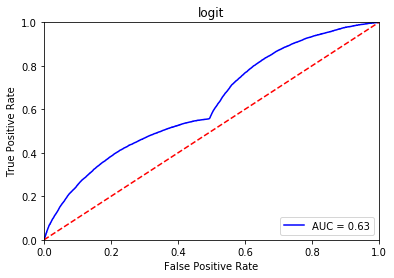

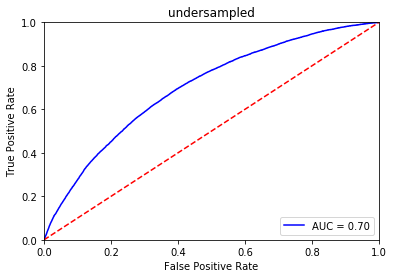

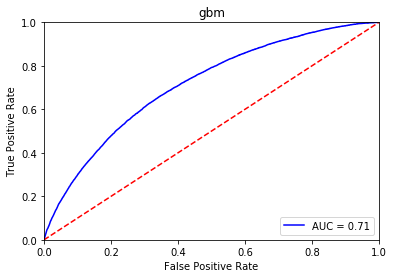

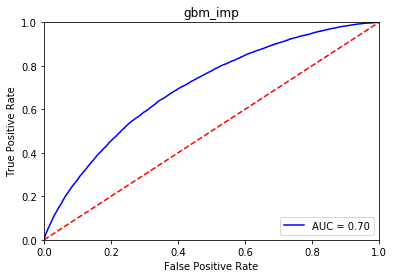

In [57]:
gbm_probs=gbm.predict_proba(X_test)[:,1]
lr_probs=lr.predict_proba(X_test)[:,1]
samp_probs=lr_samp.predict_proba(X_test)[:,1]
imp_probs=gbm_imp.predict_proba(X_test[imp_ind])[:,1]
probs_arr=[lr_probs,samp_probs,gbm_probs,imp_probs]
nms=["logit","undersampled","gbm","gbm_imp"]
for ind,i in enumerate(probs_arr):
    plot_roc(y_test, i,nms[ind])